In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
#plt.rcParams.update({   "text.usetex": True,})


In [2]:
# all output er i newtonian gauge af historiske årsager du kan overveje at udkommetnere gaugetransformation i koden senere.

Så det er rent kaos herfra

$\ddot{D} +a H\dot{D} = \frac{3}{2} H^2 \Omega_m a^2 D = \frac{3}{2} H_0^2 \frac{\Omega_0}{a} D$

In [3]:
kvec = [1e-1,1,1e1]
cosmo = Class()
cosmo.set({'H0':70, 'Omega_b':0.05, 'Omega_cdm':0.25, 'k_output_values':str(kvec).strip('[]'), 
           'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',})
cosmo.compute()
bg = cosmo.get_background()


pts = cosmo.get_perturbations()['scalar']
#plt.figure(1234123)
print(bg.keys())
#print(pts)
pts0=pts[0]
print(f"{pts0.keys()=}")


dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])
pts0.keys()=dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm'])


[-1.95220673e-06 -5.76624974e-07 -8.16088888e-08 -1.31991042e-08
 -1.85874249e-09 -2.10787416e-10 -2.02525689e-11 -1.92703090e-12
 -1.83694250e-13 -1.76633106e-14 -1.81728667e-15 -3.08422200e-16
 -2.35093802e-16 -4.54228922e-16 -6.47894084e-16 -1.16176440e-15
 -2.14081452e-15 -3.93250337e-15 -5.92455188e-15]


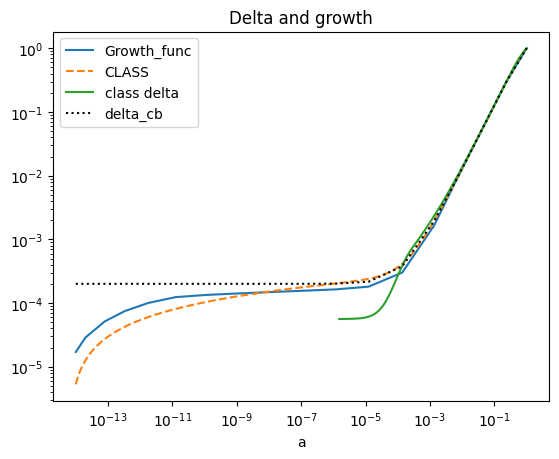

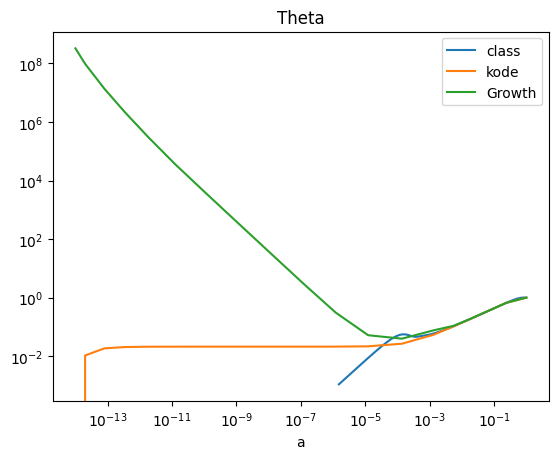

In [4]:

aend = 1
a_class = 1/(1+ bg["z"])
a0 = a_class[0]

Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
H0 = 70 / (3*1e5) # i 1/Mpc

def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

def f(a,y):
    #a = t
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

tau0 = (1/H0) * (Omega_R ** (-0.5)) * a0
sol1 = sc.solve_ivp(f,t_span=[a0,aend],y0=[tau0])

tau =sol1.y[0]
C = 1
k = 1
cs = 0
R_nu = 0

psi = 20 * C / (15 + 4 * R_nu)
theta_nu_0 =  0.5 * (k*k*tau[0]) * psi
theta_cb_0 = 0 # theta_nu_0 
delta_gamma = -2 * psi 
delta_nu_0 =delta_gamma
delta_cb_0 =  1e-14 # 4/3 * delta_gamma
phi = psi * (1 + R_nu)


def f1(t,y):
    # kun cdm så cs = 0
    # her er t = tau
    a = y[0]
    D = y[1]
    D_dt = y[2]
    delta_cb = y[3]
    theta_cb = y[4]
    #print(t)
    a_dt = a * a * H(a)
    nabla2phi = ( 3 / 2 ) * H0 * H0 * Omega_M * (delta_cb) / a 
    
    D2_dt2 = +  ((3 / 2) * H0 * H0 * Omega_M * D / a) - a * H(a) * D_dt 
    
    delta_cb_dt = - theta_cb
    
    theta_cb_dt = -  a * H(a) * theta_cb - nabla2phi - k*k * (cs*cs ) * delta_cb
    
    
    return [a_dt,D_dt,D2_dt2,delta_cb_dt,theta_cb_dt]



t_start = tau[0]
t_end = tau[-1]
a0= tau0*(H0) * (Omega_R ** (0.5))
tau_span = np.array([t_start,t_end])

D0 = 1e-14
D1 = H0*np.sqrt(Omega_R)
cdm = pts0['theta_cdm']
#theta_cb_0 = cdm[]
a0_dt = H0*np.sqrt(Omega_R)*tau0
y0 = [a0_dt, D0 , D1   ,delta_cb_0 ,theta_cb_0 ]

sol = sc.solve_ivp(f1,t_span=tau_span,y0 = y0)

tau_end = bg['conf. time [Mpc]'][-1]

tau = sol.t
a = sol.y[0]
D = sol.y[1]
D_dt = sol.y[2]
#print(D/D[-1])
delta_cdm = sol.y[3]
theta_cdm = sol.y[4]

plt.loglog(a, D/D[-1], label='Growth_func')
D_class = bg['gr.fac. D']
plt.loglog(a_class, D_class, label='CLASS', ls='--')
plt.loglog(pts0["a"],pts0['delta_cdm']/pts0['delta_cdm'][-1],label="class delta")
plt.loglog(a,delta_cdm/delta_cdm[-1],label="delta_cb",ls=":",color="black")
plt.legend()
plt.xlabel("a")
plt.title("Delta and growth")
#plt.loglog(a,theta_cdm)
#print(bg.keys())
#print(cosmo)

plt.figure(1413)
cdm = pts0['theta_cdm']
plt.title("Theta")
plt.loglog(pts0['a'],cdm/cdm[-1],label="class")
plt.loglog(a,theta_cdm/theta_cdm[-1],label="kode")

theta_test = - D_dt / D * delta_cdm
print(theta_test)
plt.loglog(a,theta_test/theta_test[-1],label="Growth")
plt.xlabel("a")
plt.legend()

Text(0.5, 1.0, 'den sidste growth faktor værdi for forskellige k divideret med en growth faktor hvor k=0')

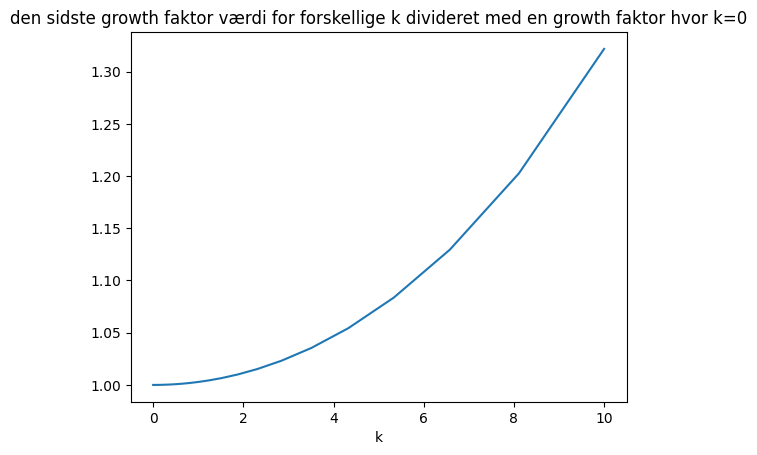

In [35]:
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
H0 = 70 / (3*1e5) # i 1/Mpc
aend = 1
a_class = 1/(1+ bg["z"])
a0 = a_class[0]
def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 
def f(a,y):
    #a = t
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)
tau0 = (1/H0) * (Omega_R ** (-0.5)) * a0
sol1 = sc.solve_ivp(f,t_span=[a0,aend],y0=[tau0])
tau =sol1.y[0]

def f1(t,y,cs,k):
    # her er t = tau
    a = y[0]
    D = y[1]
    D_dt = y[2]
    a_dt = a * a * H(a)
    D2_dt2 = 1.5 * H0 * H0 * Omega_M * D / a - a * H(a) * D_dt +  k**2 * cs**2 * D
    return [a_dt,D_dt,D2_dt2]


D0 = a0 # 4e-15
D1 = H0 * np.sqrt(Omega_R) # jeg mener at det kommer af at D' er propto a',
                           # da var noget Thomas gjorde og jeg skal lige tjekke det 
cs = 0#.31e-3
y0 = [H0 * np.sqrt(Omega_R) * tau0, D0 , D1]
sol1 = sc.solve_ivp(f1,t_span=[tau[0],tau[-1]],y0 = y0,args=(cs,0))
D_normal = sol1.y[1][-1]
k_vec = np.logspace(-8,1,100)
res = np.zeros(len(k_vec))
cs = 1e-5
i = 0
for k in k_vec:
    y0 = [H0 * np.sqrt(Omega_R) * tau0, D0 , D1]
    sol = sc.solve_ivp(f1,t_span=[tau[0],tau[-1]],y0 = y0,args=(cs,k))
    D = sol.y[1]
    res[i] =  -D[-1]/D_normal
    i += 1
# /D_normal
#res = res / res[-1]
plt.plot(k_vec,res**2)
plt.xlabel("k")
plt.title("den sidste growth faktor værdi for forskellige k divideret med en growth faktor hvor k=0")
#plt.axvline((sol1.y[1][0]/cs)**0.5,0,1)

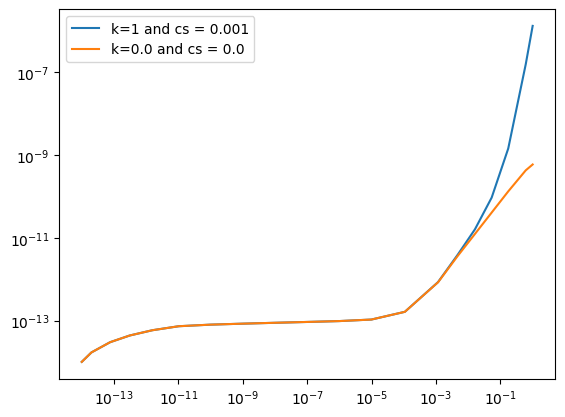

In [52]:
res = []

Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
H0 = 70 / (3*1e5) # i 1/Mpc

def f1(t,y,cs,k):
    a = y[0]
    D = y[1]
    D_dt = y[2]
    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 
    a_dt = a * a * H(a) 
    D2_dt2 = 1.5 * H0 * H0 * Omega_M * D / a - a * H(a) * D_dt + k*k*cs*cs* D
    res.append(1.5 * H0 * H0 * Omega_M * D / a)
    return [a_dt,D_dt,D2_dt2]#,0,0]

D0 = a0 
D1 = H0 * np.sqrt(Omega_R)
k1 = 1
cs1 = 0.001
y0 = [H0 * np.sqrt(Omega_R) * tau0, D0 , D1]
sol = sc.solve_ivp(f1,t_span=[tau[0],tau[-1]],y0 = y0,args=(k1,cs1))
D = sol.y[1]
a1 = sol.y[0]
plt.loglog(a1,D,label="k=%s and cs = %s" % (k1,cs1)) # /D[-1]

res1 = []
def g1(t,y,cs,k):
    a = y[0]
    D = y[1]
    D_dt = y[2]
    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 
    a_dt = a * a * H(a) 
    D2_dt2 = 1.5 * H0 * H0 * Omega_M * D / a - a * H(a) * D_dt + k*k*cs*cs* D
    res1.append(1.5 * H0 * H0 * Omega_M * D / a)
    return [a_dt,D_dt,D2_dt2]

D0 = a0 
D1 = H0 * np.sqrt(Omega_R)
k0 = 0.0
cs0 = 0.0
y01 = [H0 * np.sqrt(Omega_R) * tau0, D0 , D1]
sol1 = sc.solve_ivp(g1,t_span=[tau[0],tau[-1]],y0 = y01,args=(k0,cs0))#,0,0,0))
a2 = sol1.y[0]
plt.loglog(a2,sol1.y[1],label="k=%s and cs = %s" % (k0,cs0) ) # /sol1.y[1][-1]
plt.legend()

Text(0.5, 1.0, 'comparing different modes')

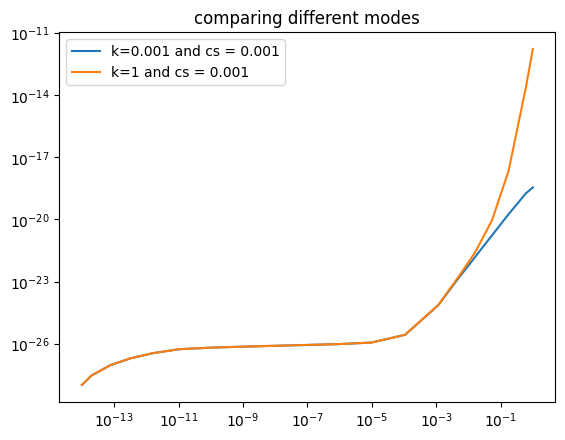

In [8]:
res = []

Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
H0 = 70 / (3*1e5) # i 1/Mpc
k1 = 0.001
cs1 = 0.001
def f1(t,y):
    cs = cs1
    k = k1
    a = y[0]
    D = y[1]
    D_dt = y[2]
    #k = y[3]
    #cs = y[4]
    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

    a_dt = a * a * H(a) 
    #D2_dt2 = 1.5 * H0 * H0 * Omega_M * D / a - a * H(a) * D_dt + k*k*cs*cs* D
    D2_dt2 = (1.5 * H0 * H0 * Omega_M /a + k*k*cs*cs) * D - a * H(a) * D_dt     
    #print( 1.5 * H0 * H0 * Omega_M * D / a)
    res.append(1.5 * H0 * H0 * Omega_M * D / a)
    #print(k*k*cs*cs* D)
    return [a_dt,D_dt,D2_dt2]#,0,0]

D0 = a0 
D1 = H0 * np.sqrt(Omega_R)

y0 = [H0 * np.sqrt(Omega_R) * tau0, D0 , D1]#,k1,cs1]
sol = sc.solve_ivp(f1,t_span=[tau[0],tau[-1]],y0 = y0)
D = sol.y[1]
a1 = sol.y[0]
plt.loglog(a1,D**2,label="k=%s and cs = %s" % (k1,cs1) ) # /D[-1]
k0 =1
cs0 = 0.001
res1 = []
def g1(t,y):
    cs = cs0
    k = k0
    a = y[0]
    D = y[1]
    D_dt = y[2]
    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 
    a_dt = a * a * H(a) 
    D2_dt2 = (1.5 * H0 * H0 * Omega_M /a + k*k*cs*cs) * D - a * H(a) * D_dt     
    return [a_dt,D_dt,D2_dt2]#,0,0]
D0 = a0 
D1 = H0 * np.sqrt(Omega_R)
y01 = [H0 * np.sqrt(Omega_R) * tau0, D0 , D1]#,k0,cs0]
sol1 = sc.solve_ivp(g1,t_span=[tau[0],tau[-1]],y0 = y01)
a2 = sol1.y[0]
plt.loglog(a2,sol1.y[1]**2,label="k=%s and cs = %s" % (k0,cs0) ) #/sol1.y[1][-1]
plt.legend()
plt.title("comparing different modes")
#plt.figure(12341)

#t = np.array([i for i in range(len(res))])
#t1 = np.array([i for i in range(len(res1))])
#plt.title("comparing different modes")
#plt.loglog(t,res)
#plt.loglog(t1,res1)


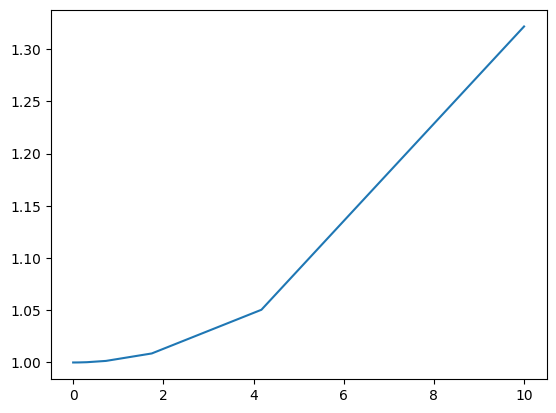

In [56]:
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
H0 = 70 / (3*1e5) # i 1/Mpc

D = sol.y[1]
a1 = sol.y[0]
#plt.loglog(a1,D**2,label="k=%s and cs = %s" % (k1,cs1) )


def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

#k0 = 0.05*3
cs0 = 0.01
n = 2
k_list = np.logspace(-10,1,30)
#[10**(i/n) for i in range(-10*n,0)]
k1 = 0
cs1 = 0
cs_list = [] #np.zeros(len(k_list))

def f(t,y,cs,k):
    a = y[0]
    D = y[1]
    D_dt = y[2]
    a_dt = a * a * H(a) 
    D2_dt2 = 1.5 * H0 * H0 * Omega_M * D / a - a * H(a) * D_dt + k*k*cs*cs* D
    return [a_dt,D_dt,D2_dt2]


for k in k_list:    
    D0 = a0 
    D1 = H0 * np.sqrt(Omega_R)
    y0 = [H0 * np.sqrt(Omega_R) * tau0, D0 , D1]
    # cs = 0 -- koden
    sol = sc.solve_ivp(f,t_span=[tau[0],tau[-1]],y0 = y0,args=(cs,0))
    D_cs0 = sol.y[1][-1]
    # cs = 0.01 -- koden
    sol1 = sc.solve_ivp(g1,t_span=[tau[0],tau[-1]],y0 = y0,args=(cs,k))
    D_cs = sol1.y[1][-1]
    cs_list.append(  (D_cs**2) / (D_cs0**2))
    
plt.plot(k_list,cs_list)
#plt.axvline((1/cs)**(-0.5),1)